# BERT


## Intro

### Bert vs ChatGPT


Bidirectional Encoder Representations Transformer



On peut répartir les transformers en deux familles:  

* ChatGPT et ses variantes: toutes les IA conversationnelles connues. Elles prédisent le futur des séquences. Elles s'entrainent sur:
    * un input: une séquence
    * un output: la même séquence décallée.
Ils sont non-anticipatif (gràce à des matrices d'attention triangulaire).


* Bert et ses variantes: RoBERTa, DistilBERT, DNABert, Nucleotide-Transformer, ProTrans (beaucoup utilisé en génétique). Elles peuvent compléter des séquences à n'importe quel endroit. Elles s'entrainent sur
    * un input: une séquence masquée en son milieu
    * un output: la séquence compléte
Le masquage à l'entrainement se fait en mettant des token "0" (aussi utilisé pour le padding). Du mascage des séquence, on déduit un masquage des matrices d'attention. On va voir cela en détail.




###  Tokenisation

In [ ]:
from datasets import load_dataset  # https://github.com/huggingface/datasets
from transformers import AutoTokenizer  # https://github.com/huggingface/transformers

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "google/bert_uncased_L-2_H-128_A-2", model_max_length=128
)

`tokenizer` fait la conversion du texte brut (des chaînes de caractères) en séquences de nombres : les jetons (=token). Dans le cas le plus simple: chaque jetons correspond à un mot possible. Par exemple:

    'bonjour' --> 344
    'hello' --> 45
    'le' --> 765
    'oiseau --> 654

Souvent on ne prend pas en compte les majuscules:

    'Bonjour' --> 344 aussi


***A vous:*** dans le code précédent, prend-t-on en compte les majuscules ?







Les tokeniseurs modernes utilisent le concepte de sous-mot.Exemple:

    bonjour  -> bon + ##jour    Non: le mot est très fréquent, il reste un token unique.
    chantons -> chant + ##ons	Le modèle apprend que chant est le radical, et ##ons est la terminaison
    chanterai-> chant + ##erai	Même radical, autre terminaison

En segmentant ainsi, le modèle apprend

* la grammaire et la conjugaison

* Les mots composés (dérivation : ex. in + égal + ité).

* Les fautes de frappe ou les mots rares (en les décomposant en morceaux connus). Par exemple: si l'on écrit "téléviserions" le modèle va le comprendre en le décomposant en (télé + ##vis + ##er + ##ions) car il a appris le (les) sens des sous-mots.

In [ ]:
def tokenize(example):
    return tokenizer(example["sentence"], padding="max_length", truncation=True)

⇑ `padding="max_length"`:  tokenizer ajoute des tokens de remplissage (padding) aux séquences qui sont plus courtes que la longueur maximale, afin qu'elles aient toutes la même taille (ici 128).

In [ ]:
ds = load_dataset("sst2")

In [ ]:
count=0
for a in ds["train"].iter(batch_size=1):
    count+=1
    print(a)
    if count>4:
        break

⇑  On charge l'ensemble de données SST-2 (Stanford Sentiment Treebank) qui concerne la classification de sentiment: positif/négatif.


`ds` (data-set) est maintenant un objet contenant  les splits train, validation et test.

In [ ]:
ds = ds.map(tokenize, batched=True)

⇑ Applique la fonction tokenize à chaque élément de `ds`


batched=True: Cette option permet de traiter les données par lots plutôt qu'un élément à la fois. C'est plus rapide.


In [ ]:
count=0
for a in ds["train"].iter(batch_size=1):
    count+=1
    print(a)
    if count>4:
        break

In [ ]:
count=0
for a in ds["train"].iter(batch_size=2):
    count+=1
    print(a)
    if count>4:
        break

In [ ]:
ds.set_format(type="jax", columns=["input_ids", "token_type_ids", "label"])

⇑ on convertit en jax. On ne garde que certaines colonnes.  

In [ ]:
count=0
for a in ds["train"].iter(batch_size=1):
    count+=1
    print(a["input_ids"])
    if count>4:
        break

### Installation

In [ ]:
!pip install equinox jaxtyping

In [ ]:
import functools
from collections.abc import Mapping
import einops  # https://github.com/arogozhnikov/einops
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int  # https://github.com/google/jaxtyping
from tqdm import notebook as tqdm  # https://github.com/tqdm/tqdm

In [ ]:
import jax.random as jr

##  implementation


* Bert est un transformer

* Il commence par transformer les jetons en vecteurs avec sont `EmbedderBlock`


* On leur applique une succession de `TransformerLayer`, chacun étant constitué d'un  `AttentionBlock` et d'un `FeedForwardBlock`.

* Comme on fait de la classification, la sortie du dernier block est poolée (réduite à un unique vecteur) plus réduite à un unique logits (classif binaire) avec un layer linéaire.  

### Embedding

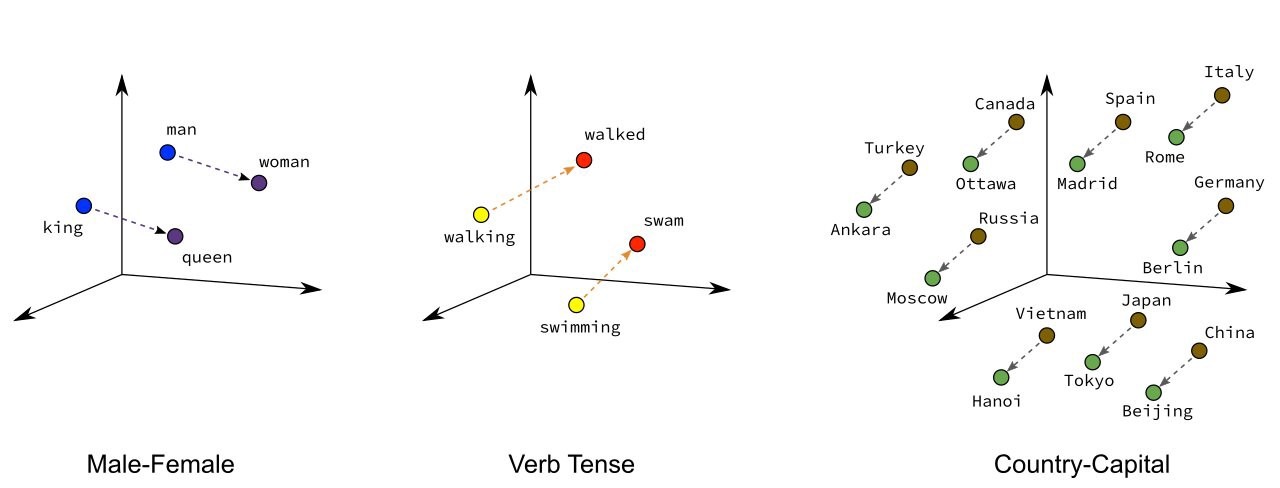

In [ ]:
def test():
    vocab_size = 100   # La taille du vocabulaire (nombre unique de jetons/mots)
    embedding_size = 4 # La dimension du vecteur de plongement pour chaque jeton
    key = jax.random.PRNGKey(42)

    #  Création du module
    key, subkey = jax.random.split(key)
    embedding_layer = eqx.nn.Embedding(
        num_embeddings=vocab_size,
        embedding_size=embedding_size,
        key=subkey
    )

    # Un input constitué de 5 jetons entre 0 et vocab_size - 1.
    input_indices = jnp.array([10, 50, 10, 99, 50], dtype=jnp.int32)


    # Application de l'embedding.
    # Le module consulte la table de poids et récupère le vecteur correspondant à chaque token (sans copie).
    embedded_output = jax.vmap(embedding_layer)(input_indices)
    #NON:embedded_output = embedding_layer(input_indices)

    print(embedded_output)
test()

In [ ]:
class EmbedderBlock(eqx.Module):
    """BERT embedder."""

    token_embedder: eqx.nn.Embedding
    segment_embedder: eqx.nn.Embedding
    position_embedder: eqx.nn.Embedding
    layernorm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        vocab_size: int,
        max_length: int,
        type_vocab_size: int,
        embedding_size: int,
        hidden_size: int,
        dropout_rate: float,
        key: jax.random.PRNGKey,
    ):
        token_key, segment_key, position_key = jax.random.split(key, 3)

        self.token_embedder = eqx.nn.Embedding(
            num_embeddings=vocab_size, embedding_size=embedding_size, key=token_key
        )
        self.segment_embedder = eqx.nn.Embedding(
            num_embeddings=type_vocab_size,
            embedding_size=embedding_size,
            key=segment_key,
        )
        self.position_embedder = eqx.nn.Embedding(
            num_embeddings=max_length, embedding_size=embedding_size, key=position_key
        )
        self.layernorm = eqx.nn.LayerNorm(shape=hidden_size)
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(
        self,
        token_ids: Int[Array, " seq_len"],
        position_ids: Int[Array, " seq_len"],
        segment_ids: Int[Array, " seq_len"],
        enable_dropout: bool = False,
        key = None,
    ) -> Float[Array, "seq_len hidden_size"]:
        tokens = jax.vmap(self.token_embedder)(token_ids)
        segments = jax.vmap(self.segment_embedder)(segment_ids)
        positions = jax.vmap(self.position_embedder)(position_ids)
        embedded_inputs = tokens + segments + positions
        embedded_inputs = jax.vmap(self.layernorm)(embedded_inputs)
        embedded_inputs = self.dropout(
            embedded_inputs, inference=not enable_dropout, key=key
        )
        return embedded_inputs

### Feed forward

In [ ]:
class FeedForwardBlock(eqx.Module):
    """A single transformer feed forward block."""

    mlp: eqx.nn.Linear
    output: eqx.nn.Linear
    layernorm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        hidden_size: int,
        intermediate_size: int,
        dropout_rate: float,
        key: jax.random.PRNGKey,
    ):
        mlp_key, output_key = jax.random.split(key)
        self.mlp = eqx.nn.Linear(
            in_features=hidden_size, out_features=intermediate_size, key=mlp_key
        )
        self.output = eqx.nn.Linear(
            in_features=intermediate_size, out_features=hidden_size, key=output_key
        )

        self.layernorm = eqx.nn.LayerNorm(shape=hidden_size)
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(
        self,
        inputs: Float[Array, " hidden_size"],
        enable_dropout: bool = True,
        key = None,
    ) -> Float[Array, " hidden_size"]:
        # Feed-forward.
        hidden = self.mlp(inputs)
        hidden = jax.nn.gelu(hidden)

        # Project back to input size.
        output = self.output(hidden)
        output = self.dropout(output, inference=not enable_dropout, key=key)

        # Residual and layer norm.
        output += inputs
        output = self.layernorm(output)

        return output

⇑ Résumé du code, en notant `:x:` le dropout et `|x|` la layer normalisation:

    def FF(x): #x: (hidden_size,)
        
        h = mlp_1(x)  #(intermediate_size,)
        h = gelu(h)
        h = mlp_2(h)  #(hidden_size,)
        h = :h:
        y = h+x
        return |y|    #(hidden_size,)

### Block d'attention

In [ ]:
class AttentionBlock(eqx.Module):
    """A single transformer attention block."""

    attention: eqx.nn.MultiheadAttention
    layernorm: eqx.nn.LayerNorm
    dropout: eqx.nn.Dropout
    num_heads: int = eqx.field(static=True)

    def __init__(
        self,
        hidden_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jax.random.PRNGKey,
    ):
        self.num_heads = num_heads
        self.attention = eqx.nn.MultiheadAttention(
            num_heads=num_heads,
            query_size=hidden_size,
            use_query_bias=True,
            use_key_bias=True,
            use_value_bias=True,
            use_output_bias=True,
            dropout_p=attention_dropout_rate,
            key=key,
        )
        self.layernorm = eqx.nn.LayerNorm(shape=hidden_size)
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(
        self,
        inputs: Float[Array, "seq_len hidden_size"],
        mask: Int[Array, " seq_len"] | None,
        enable_dropout: bool = False,
        key: "jax.random.PRNGKey" = None,
    ) -> Float[Array, "seq_len hidden_size"]:

        if mask is not None:
            mask = self.make_self_attention_mask(mask)
        attention_key, dropout_key = (
            (None, None) if key is None else jax.random.split(key)
        )

        attention_output = self.attention(
            query=inputs,
            key_=inputs,
            value=inputs,
            mask=mask,
            inference=not enable_dropout,
            key=attention_key,
        )

        result = attention_output
        result = self.dropout(result, inference=not enable_dropout, key=dropout_key)
        result = result + inputs
        result = jax.vmap(self.layernorm)(result)
        return result

    def make_self_attention_mask(
        self, mask: Int[Array, " seq_len"]
    ) -> Float[Array, "num_heads seq_len seq_len"]:
        """Create self-attention mask from sequence-level mask."""
        mask = jnp.multiply(
            jnp.expand_dims(mask, axis=-1), jnp.expand_dims(mask, axis=-2)
        )
        mask = jnp.expand_dims(mask, axis=-3)
        mask = jnp.repeat(mask, repeats=self.num_heads, axis=-3)
        return mask.astype(jnp.float32)

⇑ résumé:



        def attention_block(X,mask):
            Mask = make_self_attention_mask(mask)
            H = mha(X,X,X,Mask)
            H = :H: + X
            return |H|



*  `|H|` représente la layer normalization suivant l'axe des features.

* Les tenseurs `X,H` ci-dessous ont pour shape `(seq_len,hidden_size)`.

* `mask` est un vecteur de booléen de taille `seq_len` in diquant les mots à masquer.  

* `Mask` est un tenseur de booléen de shape `(num_heads,seq_len,seq_len)`. Voir ci dessous.


In [ ]:
def test():
    attentionBlock=AttentionBlock(
        hidden_size=3,
        num_heads= 2,
        dropout_rate= 0.5,
        attention_dropout_rate= 0.5,
        key=jr.key(0))

    #seq_len=5
    mask=jnp.array([True,True,False,False,True])
    mask=attentionBlock.make_self_attention_mask(mask)
    print(mask)
test()

⇑ c'est le même masque pour toute les têtes.

### Transformer layer

In [ ]:
class TransformerLayer(eqx.Module):
    """A single transformer layer."""

    attention_block: AttentionBlock
    ff_block: FeedForwardBlock

    def __init__(
        self,
        hidden_size: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jax.random.PRNGKey,
    ):
        attention_key, ff_key = jax.random.split(key)

        self.attention_block = AttentionBlock(
            hidden_size=hidden_size,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=attention_key,
        )
        self.ff_block = FeedForwardBlock(
            hidden_size=hidden_size,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )

    def __call__(
        self,
        inputs: Float[Array, "seq_len hidden_size"],
        mask: Int[Array, " seq_len"] | None = None,
        *,
        enable_dropout: bool = False,
        key = None,
    ) -> Float[Array, "seq_len hidden_size"]:
        attn_key, ff_key = (None, None) if key is None else jax.random.split(key)
        attention_output = self.attention_block(
            inputs, mask, enable_dropout=enable_dropout, key=attn_key
        )
        seq_len = inputs.shape[0]
        ff_keys = None if ff_key is None else jax.random.split(ff_key, num=seq_len)
        output = jax.vmap(self.ff_block, in_axes=(0, None, 0))(
            attention_output, enable_dropout, ff_keys
        )
        return output

⇑ Résumé:

        def transformer_layer(X,mask):
            H = attention_block(X,mask)
            return vmap(FF)(H)


Notons que, via le vmap, on applique le même layer FF à tous les temps de la séquence `H`.

### Encoder

In [ ]:
class Encoder(eqx.Module):
    """Full BERT encoder."""

    embedder_block: EmbedderBlock
    layers: list[TransformerLayer]
    pooler: eqx.nn.Linear

    def __init__(
        self,
        vocab_size: int,
        max_length: int,
        type_vocab_size: int,
        embedding_size: int,
        hidden_size: int,
        intermediate_size: int,
        num_layers: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jax.random.PRNGKey,
    ):
        embedder_key, layer_key, pooler_key = jax.random.split(key, num=3)
        self.embedder_block = EmbedderBlock(
            vocab_size=vocab_size,
            max_length=max_length,
            type_vocab_size=type_vocab_size,
            embedding_size=embedding_size,
            hidden_size=hidden_size,
            dropout_rate=dropout_rate,
            key=embedder_key,
        )

        layer_keys = jax.random.split(layer_key, num=num_layers)
        self.layers = []
        for layer_key in layer_keys:
            self.layers.append(
                TransformerLayer(
                    hidden_size=hidden_size,
                    intermediate_size=intermediate_size,
                    num_heads=num_heads,
                    dropout_rate=dropout_rate,
                    attention_dropout_rate=attention_dropout_rate,
                    key=layer_key,
                )
            )

        self.pooler = eqx.nn.Linear(
            in_features=hidden_size, out_features=hidden_size, key=pooler_key
        )

    def __call__(
        self,
        token_ids: Int[Array, " seq_len"],
        position_ids: Int[Array, " seq_len"],
        segment_ids: Int[Array, " seq_len"],
        *,
        enable_dropout: bool = False,
        key = None,
    ) -> dict[str, Array]:
        emb_key, l_key = (None, None) if key is None else jax.random.split(key)

        embeddings = self.embedder_block(
            token_ids=token_ids,
            position_ids=position_ids,
            segment_ids=segment_ids,
            enable_dropout=enable_dropout,
            key=emb_key,
        )

        # We assume that all 0-values should be masked out.
        mask = jnp.asarray(token_ids != 0, dtype=jnp.int32)

        x = embeddings
        layer_outputs = []
        for layer in self.layers:
            cl_key, l_key = (None, None) if l_key is None else jax.random.split(l_key)
            x = layer(x, mask, enable_dropout=enable_dropout, key=cl_key)
            layer_outputs.append(x)

        # BERT pooling.
        # The first token in the last layer is the embedding of the "[CLS]" token.
        first_token_last_layer = x[..., 0, :]
        pooled = self.pooler(first_token_last_layer)
        pooled = jnp.tanh(pooled)

        return {"embeddings": embeddings, "layers": layer_outputs, "pooled": pooled}

⇑ Résumé


    def encoder(token_ids,position_ids,segment_ids):

        mask = (token_ids!=0)

        H = embed(token_ids,position_ids,segment_ids)
        for i in range(n_layer):
            H =transformer_layer_i(H,mask)

        #Pooling
        pooled=tanh(pooler(H[0, :]))

        return pooled





Remarque: e passage de mask->Mask est effectué plusieurs fois. Si le nombre de layer est grand c'est dommage.


### BertClassifier

In [ ]:
class BertClassifier(eqx.Module):
    """BERT classifier."""

    encoder: Encoder
    classifier_head: eqx.nn.Linear
    dropout: eqx.nn.Dropout

    def __init__(self, config: Mapping, num_classes: int, key: jax.random.PRNGKey):
        encoder_key, head_key = jax.random.split(key)

        self.encoder = Encoder(
            vocab_size=config["vocab_size"],
            max_length=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            embedding_size=config["hidden_size"],
            hidden_size=config["hidden_size"],
            intermediate_size=config["intermediate_size"],
            num_layers=config["num_hidden_layers"],
            num_heads=config["num_attention_heads"],
            dropout_rate=config["hidden_dropout_prob"],
            attention_dropout_rate=config["attention_probs_dropout_prob"],
            key=encoder_key,
        )
        self.classifier_head = eqx.nn.Linear(
            in_features=config["hidden_size"], out_features=num_classes, key=head_key
        )
        self.dropout = eqx.nn.Dropout(config["hidden_dropout_prob"])

    def __call__(
        self,
        inputs: dict[str, Int[Array, " seq_len"]],
        enable_dropout: bool = True,
        key: jax.random.PRNGKey = None,
    ) -> Float[Array, " num_classes"]:
        seq_len = inputs["token_ids"].shape[-1]
        position_ids = jnp.arange(seq_len)

        e_key, d_key = (None, None) if key is None else jax.random.split(key)

        pooled_output = self.encoder(
            token_ids=inputs["token_ids"],
            segment_ids=inputs["segment_ids"],
            position_ids=position_ids,
            enable_dropout=enable_dropout,
            key=e_key,
        )["pooled"]
        pooled_output = self.dropout(
            pooled_output, inference=not enable_dropout, key=d_key
        )

        return self.classifier_head(pooled_output)

⇑ Résumé:


    def bert_classifier(token_ids, segment_ids):

        position_ids = [0,1,...,seq_len-1]
        pooled = encoder(token_ids, segment_ids,position_ids)    #(hidden_size,)
        pooled = :pooled:

        return linear(pooled). #(num_classes,)





## Entrainement

## Chargement de poids


In [ ]:
# Tiny-BERT config.
bert_config = {
    "vocab_size": 30522,
    "hidden_size": 128,
    "num_hidden_layers": 2,
    "num_attention_heads": 2,
    "hidden_act": "gelu",
    "intermediate_size": 512,
    "hidden_dropout_prob": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "max_position_embeddings": 512,
    "type_vocab_size": 2,
    "initializer_range": 0.02,
}

key = jr.key(5678)
model_key, train_key = jax.random.split(key)
classifier = BertClassifier(config=bert_config, num_classes=2, key=model_key)

On télécharge un 'checkpoint' contenant des poids déjà entrainé.

In [ ]:
!wget https://raw.githubusercontent.com/patrick-kidger/equinox/main/docs/examples/bert_checkpoint.eqx

In [ ]:
# checkpoint downloaded from
# https://github.com/patrick-kidger/equinox/blob/main/docs/examples/bert_checkpoint.eqx
classifier_chkpt = eqx.tree_deserialise_leaves("bert_checkpoint.eqx", classifier)

⇑ Noté qu'equinox a besoin d'un objet 'module' (avec des poids aléatoires) pour pouvoir chaquer les poids préentrainés.

In [ ]:
# commentez la ligne ci-dessous pour partir d'un modèle non-pré-entrainé.
classifier=classifier_chkpt

# Training on SST2.


### `pmap`

In [ ]:
from functools import partial

# Détecter le nombre de dispositifs disponibles (cœurs de CPU/GPU)
num_devices = jax.device_count()
print(f"Nombre de dispositifs JAX disponibles : {num_devices}\n")

# 1. Définition de la fonction de calcul sur un seul dispositif
# Cette fonction simule le calcul d'une perte ou d'un gradient
def single_device_compute(data_slice, scale_factor):
    # Simuler un calcul (ex: carré de la moyenne locale)
    local_mean = jnp.mean(data_slice)
    local_result = local_mean**2 * scale_factor
    return local_result

# 2. Définition de la fonction parallélisée (équivalente à make_step)
# Elle sera appliquée sur tous les dispositifs par pmap
@partial(jax.pmap, axis_name='devices')
def parallel_compute_step(data_slice, scale_factor):
    # Calcul local sur chaque dispositif
    local_result = single_device_compute(data_slice, scale_factor)

    # Agrégation des résultats : c'est ici que pmean intervient.
    # On fait la moyenne du résultat (qui simule le gradient/la perte)
    # sur tous les dispositifs.
    global_result_aggregated = jax.lax.pmean(local_result, axis_name='devices')

    # Chaque dispositif renvoie la moyenne globale
    return global_result_aggregated

# --- Préparation des données ---

# Données totales (doit être divisible par num_devices)
total_data = jnp.arange(num_devices * 4)

# 3. Distribution manuelle des données (simule le Data Loader)
# Les données sont empilées pour créer un nouvel axe de tête (l'axe parallèle)
# Si 4 dispositifs, total_data est divisé en 4 tranches
data_distributed = total_data.reshape(num_devices, -1)

# Les autres paramètres doivent également avoir l'axe parallèle
# Ici, nous dupliquons un facteur d'échelle constant
scale_factors_distributed = jnp.array([2.0] * num_devices)

# --- Exécution ---

print(f"Forme des données distribuées : {data_distributed.shape} (Axis 0 = Dispositifs)")

# Appel de la fonction parallélisée
# JAX distribue automatiquement l'exécution
final_aggregated_result = parallel_compute_step(data_distributed, scale_factors_distributed)

# Le résultat renvoyé a une dimension de tête égale au nombre de dispositifs,
# mais toutes les valeurs sont identiques car pmean les a synchronisées.
print(f"\nRésultat final (forme) : {final_aggregated_result.shape}")
print(f"Résultat agrégé (valeur) : {final_aggregated_result[0]:.4f}")

### TQDM

Pour afficher une barre de progression.

In [ ]:
import time
from tqdm import tqdm

for i in tqdm(range(100)):
    # Simuler un traitement qui prend du temps
    time.sleep(0.01)

In [ ]:
import time
from tqdm import tqdm

for i in tqdm(range(100),total=10):
    # Simuler un traitement qui prend du temps
    time.sleep(0.01)

### Fonctions pour l'entrainement

On utilise `pmap` pour envoyer les batch sur les différents GPU à disposition. Si on n'en a qu'une seul, cela ne change rien.

In [ ]:
@eqx.filter_value_and_grad
def compute_loss(classifier, inputs, key):
    batch_size = inputs["token_ids"].shape[0]
    batched_keys = jax.random.split(key, num=batch_size)

    logits = jax.vmap(classifier, in_axes=(0, None, 0))(inputs, True, batched_keys)
    return jnp.mean(
        optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=inputs["label"]
        )
    )


def make_step(model, inputs, opt_state, key, tx):
    key, new_key = jax.random.split(key)
    loss, grads = compute_loss(model, inputs, key)
    grads = jax.lax.pmean(grads, axis_name="devices")

    updates, opt_state = tx.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state, new_key


def make_eval_step(model, inputs):
    return jax.vmap(functools.partial(model, enable_dropout=False))(inputs)


p_make_eval_step = eqx.filter_pmap(make_eval_step)

In [ ]:
epochs = 3
batch_size = 32
learning_rate = 1e-5

num_devices = jax.device_count()
assert batch_size % num_devices == 0, (
    "The batch size must be a multiple of the number of devices."
)
print(f"num_devices:{num_devices}")

In [ ]:
tx = optax.adam(learning_rate=learning_rate)
tx = optax.chain(optax.clip_by_global_norm(1.0), tx)
opt_state = tx.init(classifier_chkpt)

p_make_step = eqx.filter_pmap(functools.partial(make_step, tx=tx), axis_name="devices")

# Replicate across devices.
opt_state = jax.device_put_replicated(opt_state, jax.local_devices())
model = jax.device_put_replicated(classifier_chkpt, jax.local_devices())
train_key = jax.device_put_replicated(train_key, jax.local_devices())

for epoch in range(epochs):
    with tqdm.tqdm(
        ds["train"].iter(batch_size=batch_size, drop_last_batch=True),
        total=ds["train"].num_rows // batch_size,
        unit="steps",
        desc=f"Epoch {epoch + 1}/{epochs}",
    ) as tqdm_epoch:
        for batch in tqdm_epoch:
            token_ids, token_type_ids = batch["input_ids"], batch["token_type_ids"]
            label = batch["label"]

            # Split batch across devices.
            token_ids = einops.rearrange(
                token_ids, "(b1 b2) s -> b1 b2 s", b1=num_devices
            )
            token_type_ids = einops.rearrange(
                token_type_ids, "(b1 b2) s -> b1 b2 s", b1=num_devices
            )
            label = einops.rearrange(label, "(b1 b2) -> b1 b2", b1=num_devices)

            inputs = {
                "token_ids": token_ids,
                "segment_ids": token_type_ids,
                "label": label,
            }
            loss, model, opt_state, train_key = p_make_step(
                model, inputs, opt_state, train_key
            )

            tqdm_epoch.set_postfix(loss=np.sum(loss).item())

⇑ ça met un moment à démarrer, mais ensuite ça fonce (avec un GPU).

In [ ]:
outputs = []
for batch in tqdm.tqdm(
    ds["validation"].iter(batch_size=batch_size),
    unit="steps",
    total=np.ceil(ds["validation"].num_rows / batch_size),
    desc="Validation",
):
    token_ids, token_type_ids = batch["input_ids"], batch["token_type_ids"]
    label = batch["label"]

    # Split batch across devices.
    token_ids = einops.rearrange(token_ids, "(b1 b2) s -> b1 b2 s", b1=num_devices)
    token_type_ids = einops.rearrange(
        token_type_ids, "(b1 b2) s -> b1 b2 s", b1=num_devices
    )

    inputs = {"token_ids": token_ids, "segment_ids": token_type_ids}

    # Compare predicted class with label.
    output = p_make_eval_step(model, inputs)
    output = map(float, np.argmax(output.reshape(-1, 2), axis=-1) == label)
    outputs.extend(output)

print(f"Accuracy: {100 * np.sum(outputs) / len(outputs):.2f}%")

If you used the pretrained checkpoint, you should be able to achieve ~80% accuracy. If you trained from randomly initialized weights instead, expect around 60% accuracy.